In [1]:
from typing import Dict, List
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from gensim.models import KeyedVectors, Word2Vec
import pickle
from collections import Counter
from sklearn import linear_model, ensemble, svm, gaussian_process, naive_bayes, model_selection, metrics
from copy import deepcopy
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore',category=DeprecationWarning)
os.chdir('../amazon')
os.getcwd()

'/home/lesci/covariate_paper/amazon'

In [2]:
#wm = Word2Vec(corpus_file='./data/data.test.txt', sg=1, iter=5, workers=5)
#wm.wv.save_word2vec_format('./embedding_type/global.emb', binary=True)

# Train Word Embeddings
---

In [ ]:
categories = ['books', 'dvd', 'electro', 'kitchen']

### Global and Covariate Specific

In [ ]:
iterations = [5, 10, 15, 20, 50]

for i in iterations:
    print('STARTED: Training Embeddings for {} epochs'.format(i))
    print('\tTraining global embedding')
    
    wm = Word2Vec(corpus_file='./data/data.test.txt', sg=1, iter=i, workers=5)
    wm.wv.save_word2vec_format('./embedding_type/{}_global.emb'.format(i), binary=True)
    
    for cat in categories:
        print('\tTraining single {} embedding'.format(cat))
        wm = Word2Vec(corpus_file='./data/{}_text'.format(cat), sg=1, iter=i, workers=5)
        wm.wv.save_word2vec_format('./embedding_type/{}_{}.emb'.format(i, cat), binary=True)
    print('\ndone!\n\n')

### Bamman
Train on corpus using [author](https://github.com/dbamman/geoSGLM)'s code and then use the code below to create the final embeddings.

In [ ]:
with open('./embedding_type/bamman.emb', mode='r', encoding='utf-8') as f:
    next(f)
    cat = []
    word = []
    emb = []
    for line in f.readlines():
        row = line.split()
        cat.append(row[0])
        word.append(row[1])
        emb.append(np.array(row[2:], dtype=float))

bamman = pd.DataFrame({'cat':cat, 'word':word, 'emb':emb})
main = bamman.loc[bamman['cat'] == 'MAIN']

results = []
for cat in categories:
    cat_df = bamman.loc[bamman['cat'] == cat]
    df = pd.merge(cat_df, main, how='inner', on='word', suffixes=('', '_main'))
    df['emb_bamman'] = df['emb'] + df['emb_main']
    results.append(df)

for i in range(len(categories)):     
    df = results[i]
    with open('bamman_{}.emb'.format(categories[i]), 'w') as f:
        f.write('{} {}\n'.format(len(df), 100))
        for idx, data in df[['word', 'emb_bamman']].iterrows():
            f.write('{} {}\n'.format(data[0], ' '.join([str(i) for i in data[1].tolist()])))

# Retrofit
---

In [47]:
def retrofit(vectors:np.array, common_indeces, num_iters=100):
    
    N, _ = vectors.shape
    new_vectors = np.copy(vectors)
    num_neighbours = len(common_indeces)
    
    # run retrofitting
    for it in tqdm(range(num_iters)):
        new_vectors[common_indeces] = ((num_neighbours * vectors[common_indeces]) + new_vectors[common_indeces].sum(axis=0)) / (2 * num_neighbours)
    return new_vectors

In [52]:
all_files = [i for i in os.listdir('embedding_type/') if i.endswith('emb')]

for iteration in iterations:
    files = [i for i in all_files if i.startswith(str(iteration))]
    print('.', end='\r')
    
    for cat in categories:
        specific_file = next(filter(lambda x: cat in x, files))
        global_file = next(filter(lambda x: 'global' in x, files))
        s = KeyedVectors.load_word2vec_format('embedding_type/{}'.format(specific_file), binary=True)
        g = KeyedVectors.load_word2vec_format('embedding_type/{}'.format(global_file), binary=True)
                                                       
        common_words = set.intersection(set(s.index2word), set(g.index2word))
        word2index = {token: token_index for token_index, token in enumerate(g.index2word)}
        common_indeces = [word2index[i] for i in common_words] 
        retrofitted = retrofit(g.vectors, common_indeces, 100)
        g.vectors = retrofitted
        g.save_word2vec_format('embedding_type/retrofitted_{}'.format(specific_file), binary=True)        

100%|██████████| 100/100 [00:00<00:00, 127.79it/s]


100%|██████████| 100/100 [00:00<00:00, 309.64it/s]


100%|██████████| 100/100 [00:00<00:00, 281.93it/s]


100%|██████████| 100/100 [00:00<00:00, 308.57it/s]


100%|██████████| 100/100 [00:00<00:00, 340.37it/s]


# Comparisons
---

In [127]:
def create_unk(model):
    model_matrix = model.wv[model.wv.vocab]
    model_unk = np.mean(model_matrix, axis=0)
    return model_unk

def embed_concat(word_list, wv, oov_mean):
    doc = np.stack([wv[word] if word in wv.wv.vocab else oov_mean for word in word_list], axis=0)
    mean = np.mean(doc, axis=0)
    max_ = np.max(doc, axis=0)
    min_ = np.min(doc, axis=0)
    std = np.std(doc, axis=0)
    return np.concatenate([mean, max_, min_, mean+std, mean-std], axis=0)

def embed_mean(word_list, wv, oov_mean):
    doc = np.stack([wv[word] if word in wv.wv.vocab else oov_mean for word in word_list], axis=0)
    return np.mean(doc, axis=0)

In [172]:
def make_table(X:np.array, y:np.array, emb_type:str, emb_fn:str, cat:str):

    scoring = {'acc':metrics.accuracy_score, 'f1':metrics.f1_score, 
               'prec':metrics.precision_score, 'rec':metrics.recall_score}
    scoring = {k:metrics.make_scorer(v) for k,v in scoring.items()}

    models = [ensemble.RandomForestClassifier(random_state=1994), 
              svm.LinearSVC(random_state=1994), 
              linear_model.LogisticRegression(solver='lbfgs', random_state=1994), 
              linear_model.RidgeClassifier(random_state=1994), 
              ensemble.AdaBoostClassifier(random_state=1994), 
              gaussian_process.GaussianProcessClassifier(random_state=1994), 
              naive_bayes.BernoulliNB()]

    # as an alternative to train_test_split I use CV
    cv_split = model_selection.KFold(n_splits=10, shuffle=True, 
                                     random_state=1994)
    

    # create table to compare embeddings and models
    TABLE = pd.DataFrame(columns=['model', 'embed_type', 'covariate', 
                                  'fit_time', 'fit_time_sd', 
                                  'test_f1', 'test_f1_sd', 
                                  'test_acc', 'test_acc_sd', 
                                  'test_prec', 'test_prec_sd', 
                                  'test_rec', 'test_rec_sd'])
    predicted = []
    
    row_index = 0
    for algo in models:
        print(' '*100, end='\r')
        print('\t\tFitting {}'.format(algo.__class__.__name__), end='\r')
        row_index += 1
        cv_results = model_selection.cross_validate(algo, X, y, 
                                                    cv=cv_split, 
                                                    scoring=scoring, 
                                                    return_train_score=False, 
                                                    n_jobs=5, return_estimator=True)
        
        TABLE.loc[row_index, 'model'] = algo.__class__.__name__
        TABLE.loc[row_index, 'embed_type'] = emb_type
        TABLE.loc[row_index, 'embed_fn'] = emb_fn
        TABLE.loc[row_index, 'covariate'] = cat
        TABLE.loc[row_index, 'fit_time'] = cv_results['fit_time'].mean()
        TABLE.loc[row_index, 'fit_time_sd'] = cv_results['fit_time'].std()
        TABLE.loc[row_index, 'test_acc'] = cv_results['test_acc'].mean()
        TABLE.loc[row_index, 'test_acc_sd'] = cv_results['test_acc'].std()
        TABLE.loc[row_index, 'test_f1'] = cv_results['test_f1'].mean()
        TABLE.loc[row_index, 'test_f1_sd'] = cv_results['test_f1'].std()
        TABLE.loc[row_index, 'test_prec'] = cv_results['test_prec'].mean()
        TABLE.loc[row_index, 'test_prec_sd'] = cv_results['test_prec'].std()
        TABLE.loc[row_index, 'test_rec'] = cv_results['test_rec'].mean()
        TABLE.loc[row_index, 'test_rec_sd'] = cv_results['test_rec'].std()
    
        for i in cv_results['estimator']:
            predicted.append(i.predict(X))
        
    return TABLE, predicted

In [ ]:
categories = ['books', 'dvd', 'electro', 'kitchen']
results_concat = []
results_mean = []
predicted_concat = {}
predicted_mean = {}

emb_types = [i for i in os.listdir('./embedding_type/')]
for i in emb_types:
    predicted_mean[i] = []
    predicted_concat[i]= []


for cat in categories:
    print('Processing {}\n'.format(cat) + '-'*16)
    emb_types = [i for i in os.listdir('./embedding_type/') if ('global' in i) or (cat in i)]
    training_file = pd.DataFrame(pickle.load(open('./training_data/training_{}.pkl'.format(cat), 'rb')), columns=['text', 'sent'])
    y = training_file['sent'].values
    
    for i, emb_type in enumerate(emb_types):
        print(' '*100, end='\r')
        print('\t- Processing: {}/{} \t{:30}'.format(i+1, len(emb_types), emb_type))
        
        # load specific embedding
        wv = KeyedVectors.load_word2vec_format('./embedding_type/{}'.format(emb_type), binary=True)
        oov_mean = create_unk(wv)
        
        # lookup each word and create sentence vector
        embed_concat_fn = lambda x: embed_concat(x, wv, oov_mean)
        training_file['emb'] = list(training_file['text'].str.split().apply(embed_concat_fn))
        X = np.stack(training_file['emb'].values, axis=0)
        table_concat, preds = make_table(X, y, str(emb_type), 'embed_concat_fn', cat)
        results_concat.append(table_concat)
        predicted_concat[emb_type].append(preds)
        
        embed_mean_fn = lambda x: embed_mean(x, wv, oov_mean)
        training_file['emb'] = list(training_file['text'].str.split().apply(embed_mean_fn))
        X = np.stack(training_file['emb'].values, axis=0)
        table_mean, preds = make_table(X, y, str(emb_type), 'embed_mean_fn', cat)
        results_mean.append(table_mean)
        predicted_mean[emb_type].append(preds)
    print('\ndone!\n\n')


Processing books
----------------
	- Processing: 1/17 	bamman_books.emb                                                               
	- Processing: 2/17 	5_twec_books.emb                                                               
	- Processing: 3/17 	5_global.emb                                                                   
	- Processing: 4/17 	10_global.emb                                                                  
	- Processing: 5/17 	10_books.emb                                                                   
	- Processing: 6/17 	15_global.emb                                                                  
	- Processing: 7/17 	15_books.emb                                                                   
	- Processing: 8/17 	20_global.emb                                                                  
	- Processing: 9/17 	20_books.emb                                                                   
	- Processing: 10/17 	50_global.emb                      

In [230]:
res = pd.concat(results_mean + results_concat, axis=0)

res.loc[res['embed_type'].str.contains('bamman'), 'embed_type'] = 'Bamman'
res.loc[(res['embed_type'].str.contains('retrofit'))&(res['embed_type'].str.contains('twec')), 'embed_type'] = 'temp'
res.loc[res['embed_type'].str.contains('global'), 'embed_type'] = 'Global'
res.loc[res['embed_type'].str.contains('twec'), 'embed_type'] = 'TWEC'
res.loc[res['embed_type'].str.contains('retrofit'), 'embed_type'] = 'RetroFit'
res.loc[res['embed_type'].str.contains('temp'), 'embed_type'] = 'RetroFit-TWEC'

res.loc[res['embed_type'].str.contains('dvd'), 'embed_type'] = 'Covariate Specific'
res.loc[res['embed_type'].str.contains('kitchen'), 'embed_type'] = 'Covariate Specific'
res.loc[res['embed_type'].str.contains('electro'), 'embed_type'] = 'Covariate Specific'
res.loc[res['embed_type'].str.contains('books'), 'embed_type'] = 'Covariate Specific'

res['test_f1'] = res['test_f1'].astype(float) 

In [241]:
r = res[['embed_type', 'covariate', 'test_f1', 'emb', 'embed_fn', 'model']]                 \
            .sort_values(['embed_type'], ascending=False)       \
            .groupby(['covariate', 'embed_type'], as_index=True)\
            .apply(lambda x: x.nlargest(1, 'test_f1'))          \
            .droplevel(2)                                       \
            .rename(columns={'embed_type':'Embedding Type', 'covariate':'Covariates', 'test_f1':'F1-score'})
            #.drop(['covariate', 'embed_type'], axis=1)

In [242]:
r

Embedding Type Covariates  F1-score  \
covariate embed_type                                                    
books     Bamman                          Bamman      books  0.759801   
          Covariate Specific  Covariate Specific      books  0.775816   
          Global                          Global      books  0.803221   
          RetroFit                      RetroFit      books  0.785600   
          RetroFit-TWEC            RetroFit-TWEC      books  0.787504   
          TWEC                              TWEC      books  0.771996   
dvd       Bamman                          Bamman        dvd  0.799729   
          Covariate Specific  Covariate Specific        dvd  0.819430   
          Global                          Global        dvd  0.824080   
          RetroFit                      RetroFit        dvd  0.821063   
          RetroFit-TWEC            RetroFit-TWEC        dvd  0.816392   
          TWEC                              TWEC        dvd  0.800755   
electro   Bamman                          Bamman    electro  0.826680   
          Covariate Specific  Covariate Specific    electro  0.826843   
          Global                          Global    electro  0.826676   
          RetroFit                      RetroFit    electro  0.824021   
          RetroFit-TWEC            RetroFit-TWEC    electro  0.827471   
          TWEC                              TWEC    electro  0.815919   
kitchen   Bamman                          Bamman    kitchen  0.808249   
          Covariate Specific  Covariate Specific    kitchen  0.830016   
          Global                          Global    kitchen  0.824976   
          RetroFit                      RetroFit    kitchen  0.820328   
          RetroFit-TWEC            RetroFit-TWEC    kitchen  0.819434   
          TWEC                              TWEC    kitchen  0.817465   

                                                         emb         embed_fn  \
covariate embed_type                                                            
books     Bamman                            bamman_books.emb    embed_mean_fn   
          Covariate Specific                    15_books.emb    embed_mean_fn   
          Global                               50_global.emb    embed_mean_fn   
          RetroFit                  retrofitted_20_books.emb    embed_mean_fn   
          RetroFit-TWEC         retrofitted_5_twec_books.emb    embed_mean_fn   
          TWEC                              5_twec_books.emb    embed_mean_fn   
dvd       Bamman                              bamman_dvd.emb    embed_mean_fn   
          Covariate Specific                      10_dvd.emb    embed_mean_fn   
          Global                               10_global.emb    embed_mean_fn   
          RetroFit                    retrofitted_10_dvd.emb    embed_mean_fn   
          RetroFit-TWEC           retrofitted_5_twec_dvd.emb    embed_mean_fn   
          TWEC                                5_twec_dvd.emb    embed_mean_fn   
electro   Bamman                          bamman_electro.emb    embed_mean_fn   
          Covariate Specific                  50_electro.emb    embed_mean_fn   
          Global                               20_global.emb    embed_mean_fn   
          RetroFit                retrofitted_10_electro.emb    embed_mean_fn   
          RetroFit-TWEC       retrofitted_5_twec_electro.emb  embed_concat_fn   
          TWEC                            5_twec_electro.emb    embed_mean_fn   
kitchen   Bamman                          bamman_kitchen.emb  embed_concat_fn   
          Covariate Specific                  20_kitchen.emb    embed_mean_fn   
          Global                               20_global.emb    embed_mean_fn   
          RetroFit                retrofitted_20_kitchen.emb    embed_mean_fn   
          RetroFit-TWEC       retrofitted_5_twec_kitchen.emb    embed_mean_fn   
          TWEC                            5_twec_kitchen.emb    embed_mean_fn   

                            

In [492]:
a = r.pivot(index='Embedding Type', columns='Covariates', values='F1-score')
a['Average'] = a.values.mean(axis=1)
a.columns = a.columns.str.title()

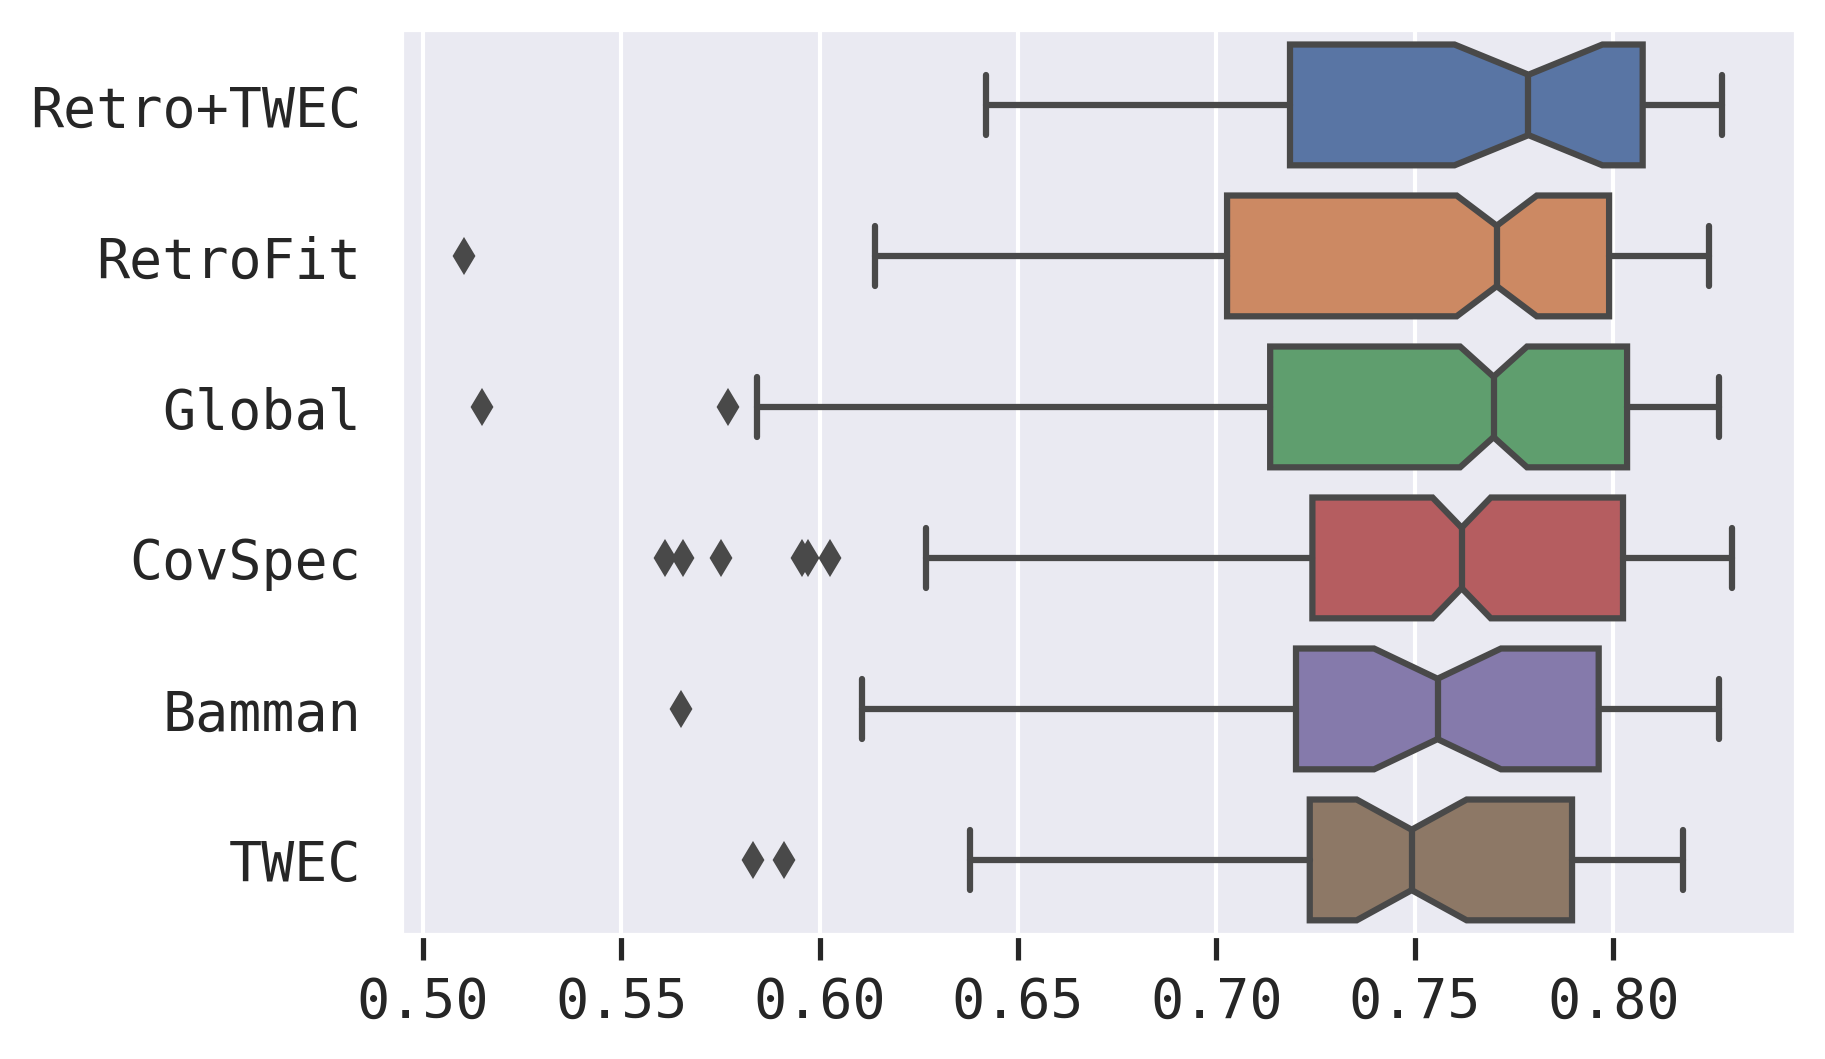

In [246]:
order = res.groupby('embed_type').agg('median').sort_values('test_f1', ascending=False).index.tolist()
#plt.figure(figsize=(10,8))
sns.set_style('whitegrid')
sns.set(font_scale = 1.2, font='monospace', rc={"xtick.bottom":True, 'figure.dpi':300})
g = sns.boxplot(y='embed_type', x='test_f1', data=res, 
            order=order, 
            palette='deep', notch=True)
g.set(yticklabels=['Retro+TWEC', 'RetroFit', 'Global', 'CovSpec', 'Bamman', 'TWEC'])
plt.ylabel('')
plt.xlabel('')
plt.show()